In [7]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score

# Setting params for matplotlib figures
plt.rcParams.update({"figure.figsize": (6, 6),
                      "axes.facecolor": "white",
                      "axes.edgecolor": "black"})

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=sb.color_palette('colorblind'))
font = {'family': 'sans-serif',
         'weight': 'normal',
         'size': 14}
plt.rc('font', **font)

file_path = 'Synthetic_ICU_Dataset_CGPT.csv'
df = pd.read_csv(file_path)
df = df.drop(columns=['Patient_ID'])

df.head()

print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10423 entries, 0 to 10422
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Admission Hospital         10423 non-null  object
 1   Admission Unit             10423 non-null  object
 2   Admission Date             10423 non-null  object
 3   Admission Decision Time    10423 non-null  object
 4   Admission Time             10423 non-null  object
 5   Discharge Date             10423 non-null  object
 6   Survived                   10423 non-null  int64 
 7   Diagnosis                  10423 non-null  object
 8   Length of Stay             10423 non-null  int64 
 9   Cardiovascular Support     10423 non-null  int64 
 10  Dialysis Support           10423 non-null  int64 
 11  Invasive Ventilation       10423 non-null  int64 
 12  Nutrition                  10423 non-null  int64 
 13  Age                        10423 non-null  int64 
 14  Gender

In [8]:
categorical_columns = ['Admission Hospital', 'Admission Unit', 'Diagnosis', 'Gender']
for column in categorical_columns:
    df[column] = df[column].astype('category')

category_names = {col: df[col].cat.categories for col in categorical_columns}

df = pd.get_dummies(df, columns=categorical_columns, drop_first=False)

print(df.head())


  Admission Date Admission Decision Time Admission Time Discharge Date  \
0     2022-07-19                   10:11          12:11     02/08/2022   
1     2022-08-22                   07:48          09:48     24/08/2022   
2     2022-01-26                   16:50          17:50     05/02/2022   
3     2022-02-11                   19:09          22:09     15/02/2022   
4     2022-03-02                   00:23          02:23     06/03/2022   

   Survived  Length of Stay  Cardiovascular Support  Dialysis Support  \
0         0              14                       1                 0   
1         1               2                       0                 0   
2         0              10                       1                 0   
3         1               4                       0                 0   
4         1               4                       0                 0   

   Invasive Ventilation  Nutrition  ...  Diagnosis_Sepsis  \
0                     0          1  ...             Fal

In [9]:
from datetime import datetime, timedelta

df['Admission Date'] = pd.to_datetime(df['Admission Date'], format='%Y-%m-%d')
df['Admission Decision Time'] = pd.to_datetime(df['Admission Decision Time'], format='%H:%M').dt.time
df['Admission Time'] = pd.to_datetime(df['Admission Time'], format='%H:%M').dt.time
df['Discharge Date'] = pd.to_datetime(df['Discharge Date'], format='%d/%m/%Y')

def calculate_wait_time(row):
    decision_datetime = datetime.combine(row['Admission Date'], row['Admission Decision Time'])
    admission_datetime = datetime.combine(row['Admission Date'], row['Admission Time'])

    if admission_datetime < decision_datetime:
        admission_datetime += timedelta(days=1) 

    return (admission_datetime - decision_datetime).total_seconds() / 3600

df['Wait Time (hrs)'] = df.apply(calculate_wait_time, axis=1)

df['Month'] = df['Admission Date'].dt.month
season_mapping = {
    11: 'Winter', 12: 'Winter', 1: 'Winter',
    2: 'Spring', 3: 'Spring', 4: 'Spring',
    5: 'Summer', 6: 'Summer', 7: 'Summer',
    8: 'Autumn', 9: 'Autumn', 10: 'Autumn'
}

df['Season'] = df['Month'].map(season_mapping)

df.to_csv('Synthetic_ICU_Dataset_CGPT2.csv', index=False)

print(df[['Admission Date', 'Month', 'Season', 'Wait Time (hrs)']].head())

  Admission Date  Month  Season  Wait Time (hrs)
0     2022-07-19      7  Summer              2.0
1     2022-08-22      8  Autumn              2.0
2     2022-01-26      1  Winter              1.0
3     2022-02-11      2  Spring              3.0
4     2022-03-02      3  Spring              2.0


In [10]:
season_order = ['Spring', 'Summer', 'Autumn', 'Winter']
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

df['Season'] = pd.Categorical(df['Season'], categories=season_order, ordered=True)
season_tally = df['Season'].value_counts().reindex(season_order)

month_mapping = {
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
    7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}
df['Month Name'] = df['Month'].map(month_mapping)
df['Month Name'] = pd.Categorical(df['Month Name'], categories=month_order, ordered=True)
month_tally = df['Month Name'].value_counts().reindex(month_order)

In [11]:
from pycaret.regression import *

df = df.sort_values(by='Admission Date')
df.set_index('Admission Date', inplace=True)

df_daily = df.resample('D').size().to_frame(name='ICU_Admissions')

print(df_daily.head())
print(df_daily.tail())
print(df_daily.columns)

reg_setup = setup(
    data=df_daily.reset_index(), 
    target='ICU_Admissions', 
    session_id=123,  
    normalize=True,
    fold=5
)

print(reg_setup)

best_model = compare_models()
print(f"Best model: {best_model}")

future_predictions = predict_model(best_model)
print(future_predictions)


                ICU_Admissions
Admission Date                
2022-01-01                  27
2022-01-02                  22
2022-01-03                  28
2022-01-04                  26
2022-01-05                  28
                ICU_Admissions
Admission Date                
2022-12-27                  26
2022-12-28                  30
2022-12-29                  27
2022-12-30                  29
2022-12-31                  36
Index(['ICU_Admissions'], dtype='object')


,Description,Value
0,Session id,123
1,Target,ICU_Admissions
2,Target type,Regression
3,Original data shape,"(365, 2)"
4,Transformed data shape,"(365, 4)"
5,Transformed train set shape,"(255, 4)"
6,Transformed test set shape,"(110, 4)"
7,Date features,1
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,3.8733,23.1525,4.7983,-0.0418,0.1686,0.1448,0.0340
ridge,Ridge Regression,3.8831,23.3016,4.8134,-0.0482,0.1690,0.1451,0.0860
lr,Linear Regression,3.8832,23.3027,4.8136,-0.0483,0.1690,0.1451,3.5260
lar,Least Angle Regression,3.8832,23.3027,4.8136,-0.0483,0.1690,0.1451,0.0460
huber,Huber Regressor,3.8933,23.3320,4.8168,-0.0498,0.1690,0.1451,0.0340
br,Bayesian Ridge,3.8802,23.3669,4.8201,-0.0510,0.1693,0.1451,0.0460
en,Elastic Net,3.8799,23.4124,4.8250,-0.0531,0.1695,0.1451,0.0360
lasso,Lasso Regression,3.8848,23.4979,4.8340,-0.0571,0.1698,0.1453,2.0200
dummy,Dummy Regressor,3.8848,23.4979,4.8340,-0.0571,0.1698,0.1453,0.0380
llar,Lasso Least Angle Regression,3.8848,23.4979,4.8340,-0.0571,0.1698,0.1453,0.0320


Best model: OrthogonalMatchingPursuit()


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Orthogonal Matching Pursuit,4.3618,29.1637,5.4003,-0.0594,0.1788,0.1507


    Admission Date  ICU_Admissions  prediction_label
59      2022-03-01              31         27.112593
309     2022-11-06              25         27.487481
9       2022-01-10              32         27.787391
299     2022-10-27              37         29.062010
242     2022-08-31              33         29.361920
..             ...             ...               ...
121     2022-05-02              25         27.187571
152     2022-06-02              29         27.187571
105     2022-04-16              39         28.237257
5       2022-01-06              25         27.487481
246     2022-09-04              24         27.337526

[110 rows x 3 columns]


In [12]:
# from pycaret.regression import *

# df = df.sort_values(by='Admission Date')
# df.set_index('Admission Date', inplace=True)

# df_daily = df.resample('D').size().to_frame(name='ICU_Admissions')

# print(df_daily.head())
# print(df_daily.tail())
# print(df_daily.columns)

# train = df_daily[:-70]
# test = df_daily[-70:]

# reg_setup = setup(
#     data=train, 
#     target='ICU_Admissions', 
#     session_id=123,  
#     normalize=True,
#     fold=5
# )

# print(reg_setup)

# best_model = compare_models()
# print(f"Best model: {best_model}")

# future_predictions = predict_model(best_model)
# print(future_predictions)

In [13]:
tuned_model = tune_model(best_model)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


   Admission Date  prediction_label
0      2023-01-01         27.112593
1      2023-01-02         27.187571
2      2023-01-03         27.262548
3      2023-01-04         27.337526
4      2023-01-05         27.412504
5      2023-01-06         27.487481
6      2023-01-07         27.562459
7      2023-01-08         27.637436
8      2023-01-09         27.712414
9      2023-01-10         27.787391
10     2023-01-11         27.862369
11     2023-01-12         27.937346
12     2023-01-13         28.012324
13     2023-01-14         28.087302
14     2023-01-15         28.162279
15     2023-01-16         28.237257
16     2023-01-17         28.312234
17     2023-01-18         28.387212
18     2023-01-19         28.462189
19     2023-01-20         28.537167
20     2023-01-21         28.612144
21     2023-01-22         28.687122
22     2023-01-23         28.762100
23     2023-01-24         28.837077
24     2023-01-25         28.912055
25     2023-01-26         28.987032
26     2023-01-27         29

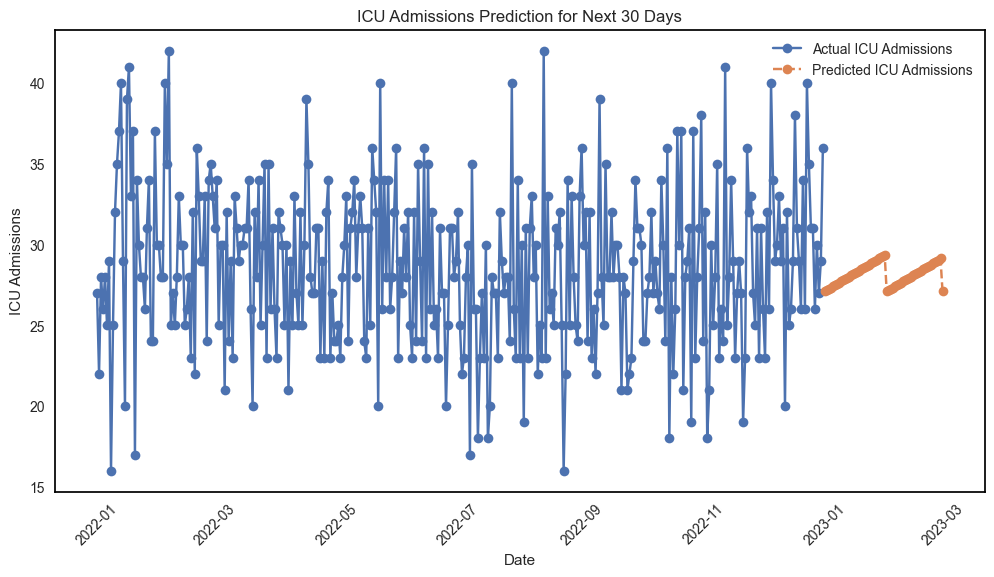

In [14]:
future_dates = pd.date_range(start=df_daily.index[-1] + pd.Timedelta(days=1), periods=60, freq='D')
future_df = pd.DataFrame({"Admission Date": future_dates})

future_predictions = predict_model(best_model, data=future_df)

print(future_predictions)

plt.figure(figsize=(12, 6))

plt.plot(df_daily.index, df_daily['ICU_Admissions'], 
         label='Actual ICU Admissions', 
         color='#4C72B0', marker='o')

plt.plot(future_predictions['Admission Date'], future_predictions['prediction_label'], 
         label='Predicted ICU Admissions', 
         color='#DD8452', linestyle='dashed', marker='o')

plt.xlabel('Date')
plt.ylabel('ICU Admissions')
plt.title('ICU Admissions Prediction for Next 30 Days')
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()

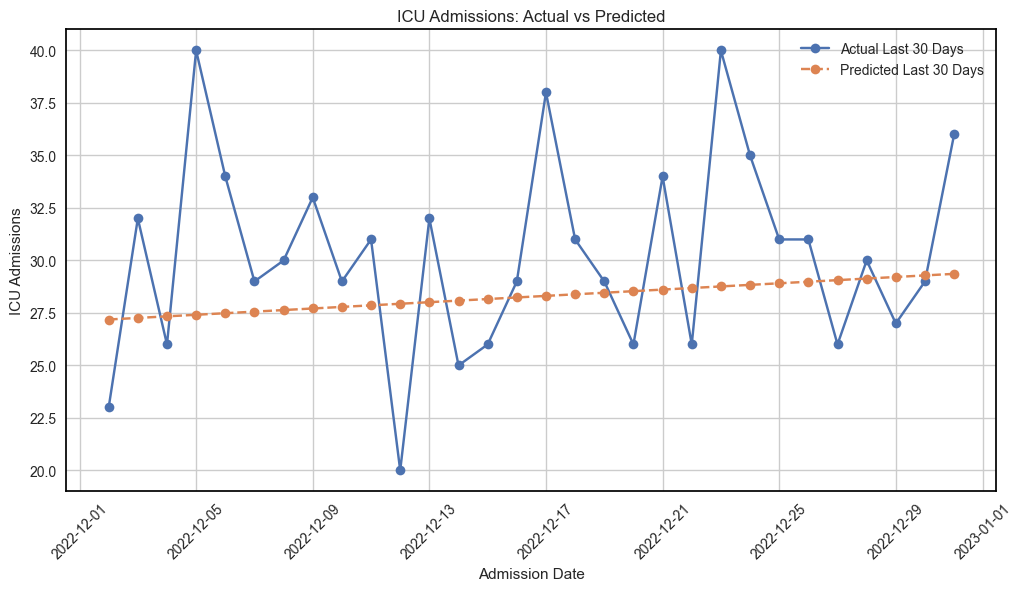

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

last_30_df = df_daily[-30:].reset_index()  
last30_predictions = predict_model(best_model, data=last_30_df)

future_dates = pd.date_range(start=df_daily.index[-1] + pd.Timedelta(days=1), periods=30, freq='D')
future_30_df = pd.DataFrame({"Admission Date": future_dates})
future30_predictions = predict_model(best_model, data=future_30_df)

plt.figure(figsize=(12, 6))

plt.plot(last30_predictions['Admission Date'], last30_predictions['ICU_Admissions'], 
         label='Actual Last 30 Days', color='#4C72B0', marker='o')

plt.plot(last30_predictions['Admission Date'], last30_predictions['prediction_label'], 
         label='Predicted Last 30 Days', color='#DD8452', linestyle='dashed', marker='o')


plt.xlabel('Admission Date')
plt.ylabel('ICU Admissions')
plt.title('ICU Admissions: Actual vs Predicted')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
